In [1]:
import cftime
import glob
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd
from scipy import stats
from scipy import io

import mission_tools

%load_ext autoreload
%autoreload 2
%matplotlib widget

## Case Study - Mission 19 
Get all wave information form mission 19

In [2]:
mission_list = ['../data/microswift_missions/mission_19.nc']
wave_heights_all = []
wave_x_locs_all = []
wave_y_locs_all = []
wave_times_all = []

for mission_nc in mission_list:
    mission_dataset = nc.Dataset(mission_nc, mode='r')
    x_locations = mission_dataset['xFRF'][:]
    y_locations = mission_dataset['yFRF'][:]
    eta = mission_dataset['sea_surface_elevation'][:]
    time = mission_dataset['time'][:]
    time_units = mission_dataset['time'].units
    time_calendar = mission_dataset['time'].calendar
    median_mission_time = np.median(time)

    wave_heights, \
    wave_x_locs, \
    wave_y_locs, \
    wave_times = mission_tools.compute_individual_waves(x_locations, y_locations,
                                                        eta, time, time_units,
                                                        time_calendar,
                                                        single_trajectory=False )
    
    wave_heights_all.append(wave_heights)
    wave_x_locs_all.append(wave_x_locs)
    wave_y_locs_all.append(wave_y_locs)
    wave_times_all.append(wave_times)

# Flatten the lists of lists
wave_heights_all = list(np.concatenate(wave_heights_all).flat)
wave_x_locs_all = list(np.concatenate(wave_x_locs_all).flat)
wave_y_locs_all = list(np.concatenate(wave_y_locs_all).flat)
wave_times_all = list(np.concatenate(wave_times_all).flat)

/Users/edwinrainville/opt/miniconda3/envs/dunex-venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/edwinrainville/opt/miniconda3/envs/dunex-venv/lib/python3.11/site-packages/numpy/ma/core.py:5288: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/Users/edwinrainville/opt/miniconda3/envs/dunex-venv/lib/python3.11/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [3]:
# Compute Bathymetry under each wave from average location
bathy_file = '../data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
wave_bathy = mission_tools.compute_wave_bathy(wave_x_locs_all,
                                              wave_y_locs_all,
                                              bathy_file)

# Adjust bathymetry for the water depths based on water level gauge
water_level_dataset = nc.Dataset('../data/FRFdata/FRF-ocean_waterlevel_eopNoaaTide_202110.nc')
water_level_time = water_level_dataset['time'][:]
water_level = water_level_dataset['waterLevel'][:]

num_waves = len(wave_times_all)
mean_water_level = np.interp(np.mean(wave_times_all),
                            water_level_time,
                            water_level)
wave_depths = []
for n in range(num_waves):
    wave_depths.append(np.abs(wave_bathy[n] - mean_water_level))

# Save Bathymetry Data
bathy_dataset = nc.Dataset(bathy_file)
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],
                                       bathy_dataset['yFRF'][:])
bathy = bathy_dataset['elevation'][0,:,:]
bathy_time = cftime.num2pydate(bathy_dataset['time'][0], 
                units=bathy_dataset['time'].units,
                calendar=bathy_dataset['time'].calendar)
print(f'The bathymetry measurements were taken on {bathy_time}')
bathy_dataset.close()
water_depth = bathy - mean_water_level

The bathymetry measurements were taken on 2021-10-21 00:00:00


In [4]:
# Create a pandas dataframe from all wave data
wave_df = pd.DataFrame(cftime.num2pydate(wave_times_all, units=time_units,
                       calendar=time_calendar), columns=['time'])
wave_df['height [m]'] = wave_heights_all
wave_df['cross shore location [m]'] = wave_x_locs_all
wave_df['along shore location [m]'] = wave_y_locs_all
wave_df['depth [m]'] = wave_depths

# Average time of the mission
mission_mean_time_num = np.mean(wave_times_all)
mission_mean_time = cftime.num2pydate(mission_mean_time_num, units=time_units,
                                      calendar=time_calendar)
print(f'Average Time in Mission: {mission_mean_time}')

# Remove any rows that have nan values for depth - occurs when they drift
# out of the measured area
wave_df = wave_df.dropna()

wave_df

Average Time in Mission: 2021-10-08 18:30:01.120797


,time,height [m],cross shore location [m],along shore location [m],depth [m]
0,2021-10-08 18:18:12.041619,0.671100,557.720271,344.549794,5.902943
1,2021-10-08 18:18:18.083261,1.039608,557.720271,344.549794,5.902943
2,2021-10-08 18:18:24.208236,0.755234,557.720271,344.549794,5.902943
3,2021-10-08 18:18:28.874885,0.332388,557.720271,344.549794,5.902943
4,2021-10-08 18:18:31.916539,0.544687,557.720271,344.549794,5.902943
...,...,...,...,...,...
4703,2021-10-08 18:40:09.203017,0.535546,172.826312,78.981325,0.650854
4704,2021-10-08 18:40:16.452987,0.563286,165.655731,75.596973,0.773580
4705,2021-10-08 18:40:25.661284,1.013731,162.238442,71.128093,0.875582
4706,2021-10-08 18:40:32.952921,0.825153,160.353987,67.188324,0.935800


Notes on this case study:
- This mission occured 13 days before the bathymetry was measured, so we expect discrepancies between the actual bathymetry at this time and the bathymetry we are using. For now we will make the assumption that this bathymetry is useful in a first order estimate.
- We do have a bathymetry survey that was conducted on October 8th which is the same day as this mission - we can use this in the future

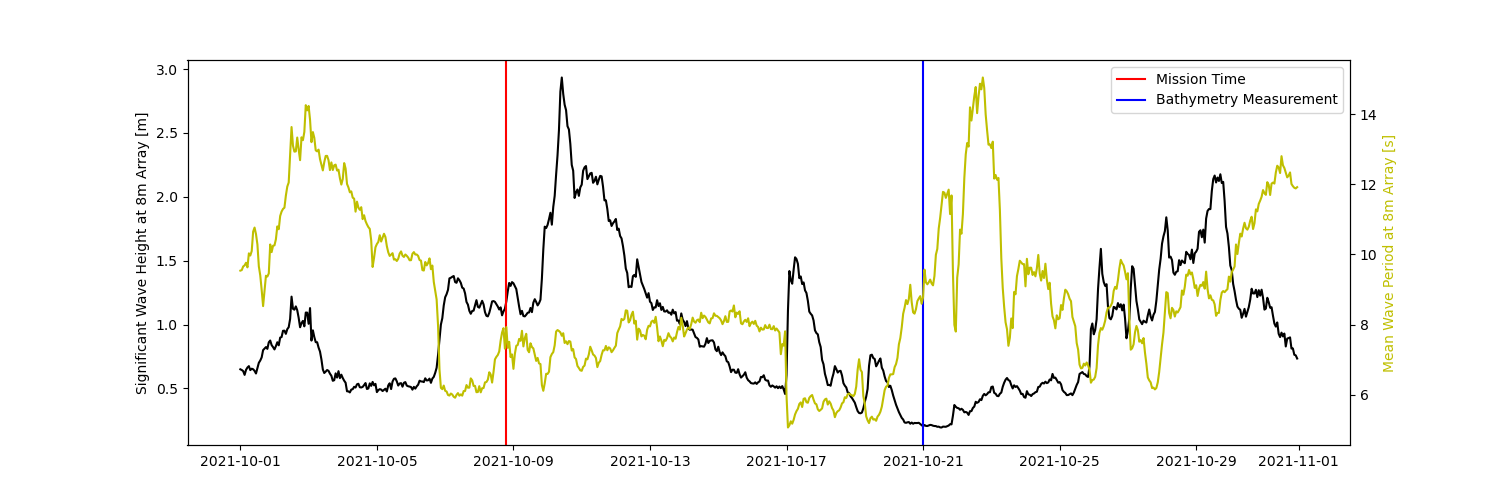

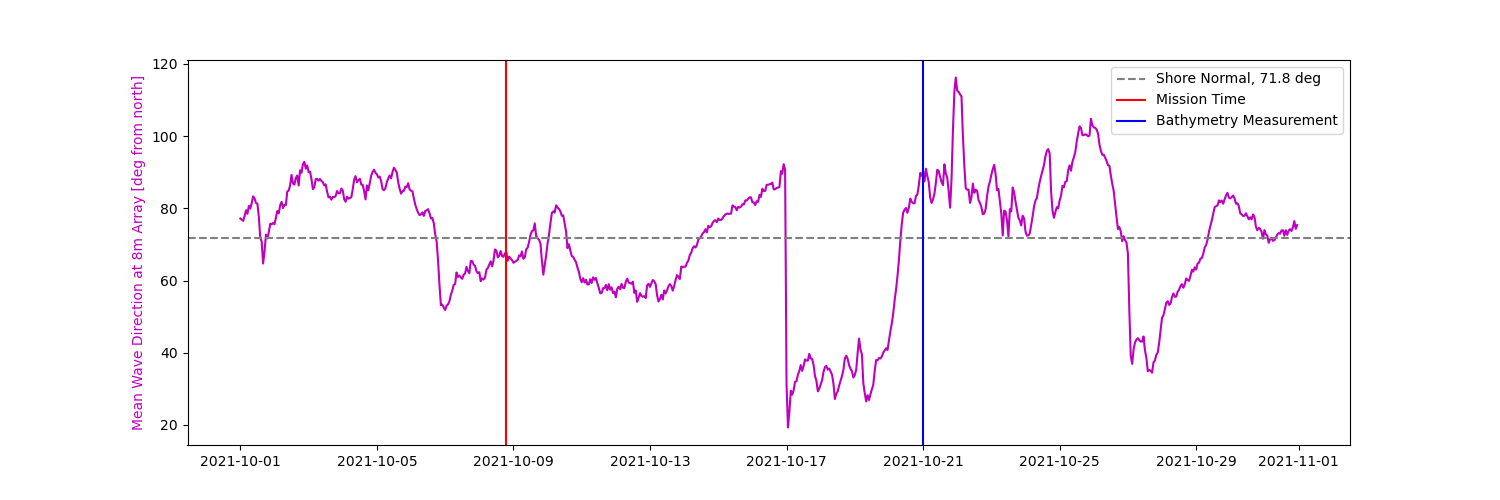

In [5]:
# Offshore Conditions during the mission - Using 8 m array
offshore_waves_dataset = nc.Dataset('../data/FRFdata/FRF-ocean_waves_8m-array_202110.nc')
offshore_waves_time = offshore_waves_dataset['time'][:]
offshore_waves_time_datetime = cftime.num2pydate(offshore_waves_time, 
                                units=offshore_waves_dataset['time'].units,
                                calendar=offshore_waves_dataset['time'].calendar)
Hs_offshore = offshore_waves_dataset['waveHs'][:]
Tm_offshore = offshore_waves_dataset['waveTm'][:]
mean_dir_offshore = offshore_waves_dataset['waveMeanDirection'][:]

fig, ax1 = plt.subplots(figsize=(15,5))
ax1.plot(offshore_waves_time_datetime, Hs_offshore, color='k')
ax1.set_ylabel('Significant Wave Height at 8m Array [m]')
ax1.axvline(mission_mean_time, color='r', label='Mission Time')
ax1.axvline(bathy_time, color='b', label='Bathymetry Measurement')
ax1.legend()

ax2 = ax1.twinx() 
ax2.plot(offshore_waves_time_datetime, Tm_offshore, color='y')
ax2.set_ylabel('Mean Wave Period at 8m Array [s]', color='y')

fig, ax3 = plt.subplots(figsize=(15,5))
ax3.plot(offshore_waves_time_datetime, mean_dir_offshore, color='m')
ax3.set_ylabel('Mean Wave Direction at 8m Array [deg from north]', color='m')
ax3.axhline(71.8, color='gray', linestyle='dashed', label='Shore Normal, 71.8 deg')
ax3.axvline(mission_mean_time, color='r', label='Mission Time')
ax3.axvline(bathy_time, color='b', label='Bathymetry Measurement')
ax3.legend()

In [6]:
# Conditions during the mission
Hs_offshore_inmission = np.interp(mission_mean_time_num, offshore_waves_time, Hs_offshore)
Tm_offshore_inmission = np.interp(mission_mean_time_num, offshore_waves_time, Tm_offshore)
mean_dir_offshore_inmission = np.interp(mission_mean_time_num, offshore_waves_time, mean_dir_offshore)
offshore_measurement_cross_shore_loc = 900

# Wave Energy Density Offshore 
wave_frequency = offshore_waves_dataset['waveFrequency'][:]
wave_dir_bins = offshore_waves_dataset['waveDirectionBins'][:]
wave_energy_offshore_inmission = np.empty(wave_frequency.shape)
dir_wave_energy_offshore_inmission = np.empty((wave_frequency.size, wave_dir_bins.size))
for n in range(wave_frequency.size):
    wave_energy_offshore_inmission[n] = np.interp(mission_mean_time_num, offshore_waves_time, offshore_waves_dataset['waveEnergyDensity'][:,n])
    # for i in range(wave_dir_bins.size):
    #     dir_wave_energy_offshore_inmission[n, i] = np.interp(mission_mean_time_num,
    #                                                         offshore_waves_time, 
    #                                                         offshore_waves_dataset['directionalWaveEnergyDensity'][n,i,:])

Offshore significant wave height during this mission was 1.15 meters.
Offshore mean wave period during this mission was 7.62 seconds.
Offshore mean wave direction during this mission was 67.68 degrees from north.This is 4.12 degrees north of shore normal.


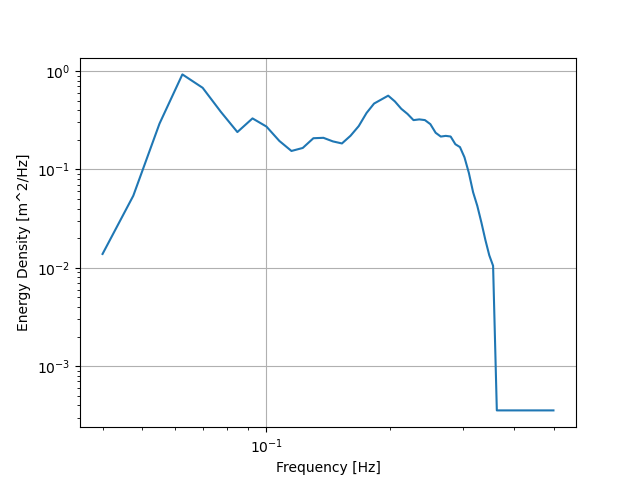

In [7]:
# Print and plot all Offshore Conditions
print(f'Offshore significant wave height during this mission was {np.round(Hs_offshore_inmission, 2)} meters.')
print(f'Offshore mean wave period during this mission was {np.round(Tm_offshore_inmission, 2)} seconds.')
print(f'Offshore mean wave direction during this mission was {np.round(mean_dir_offshore_inmission, 2)} degrees from north.' \
     f'This is {np.round(71.8-mean_dir_offshore_inmission, 2)} degrees north of shore normal.')

# Plot the 1-d spectra
fig, ax1 = plt.subplots()
ax1.loglog(wave_frequency, wave_energy_offshore_inmission)
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Energy Density [m^2/Hz]')
ax1.grid()

Note: weird high energy tail on the spectra

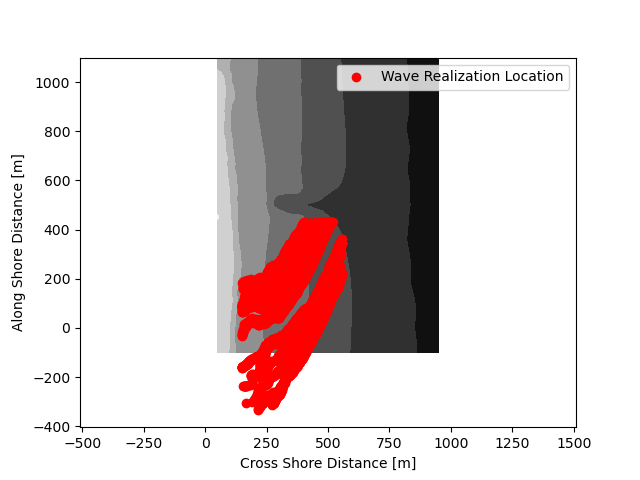

In [8]:
# Plot the Location of all waves over the Bathymetry
fig, ax = plt.subplots()
ax.contourf(xFRF_grid, yFRF_grid, water_depth, cmap='gray')
ax.scatter(wave_df['cross shore location [m]'], wave_df['along shore location [m]'],
          color='r', label='Wave Realization Location')
ax.axis('equal')
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Along Shore Distance [m]')
ax.legend()

In [9]:
# Compute Phase Speed of each wave
g = 9.8 # gravitational acceleration 
wave_df['phase speed [m/s]'] = np.sqrt(g * wave_df['depth [m]'])

wave_df

,time,height [m],cross shore location [m],along shore location [m],depth [m],phase speed [m/s]
0,2021-10-08 18:18:12.041619,0.671100,557.720271,344.549794,5.902943,7.605842
1,2021-10-08 18:18:18.083261,1.039608,557.720271,344.549794,5.902943,7.605842
2,2021-10-08 18:18:24.208236,0.755234,557.720271,344.549794,5.902943,7.605842
3,2021-10-08 18:18:28.874885,0.332388,557.720271,344.549794,5.902943,7.605842
4,2021-10-08 18:18:31.916539,0.544687,557.720271,344.549794,5.902943,7.605842
...,...,...,...,...,...,...
4703,2021-10-08 18:40:09.203017,0.535546,172.826312,78.981325,0.650854,2.525543
4704,2021-10-08 18:40:16.452987,0.563286,165.655731,75.596973,0.773580,2.753377
4705,2021-10-08 18:40:25.661284,1.013731,162.238442,71.128093,0.875582,2.929284
4706,2021-10-08 18:40:32.952921,0.825153,160.353987,67.188324,0.935800,3.028340


In [10]:
# Organize the waves into Cross shore Distance Bins
cross_shore_bin_size = 30
cross_shore_min = np.min(wave_df['cross shore location [m]'])
cross_shore_max = np.max(wave_df['cross shore location [m]'])
cross_shore_num_bins = int(np.floor((cross_shore_max - cross_shore_min)/ \
                                 cross_shore_bin_size))

cross_shore_bin_edges = np.linspace(cross_shore_min, cross_shore_max,
                                    cross_shore_num_bins)

cross_shore_bin_centers = (cross_shore_bin_edges[1:] + \
                           cross_shore_bin_edges[:-1]) / 2

h_rms_profile = []
wave_heights_in_bins = []
mean_depth_profile = []
phase_speed_profile = []
num_waves_in_bin = []
for n in range(cross_shore_bin_centers.size):
    df = wave_df[wave_df['cross shore location [m]'].between(cross_shore_bin_edges[n], 
                                                             cross_shore_bin_edges[n+1])]
    wave_heights_in_bins.append(df['height [m]'])
    h_rms_profile.append(np.sqrt(np.mean(np.power(df['height [m]'], 2))))
    mean_depth_profile.append(np.mean(df['depth [m]']))
    phase_speed_profile.append(np.mean(df['phase speed [m/s]']))
    num_waves_in_bin.append(len(df.index))

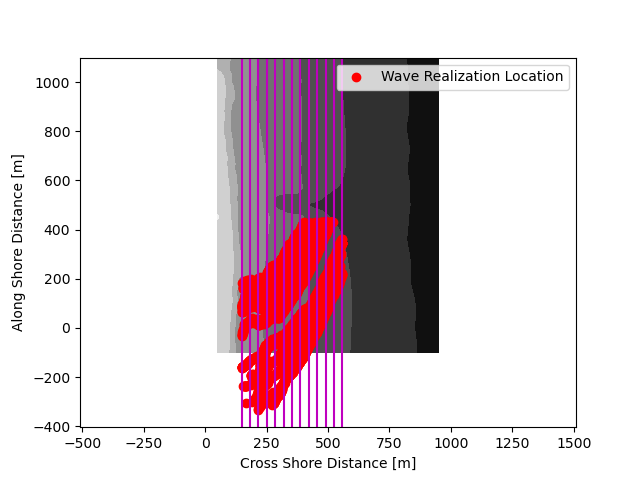

In [11]:
# Plot the Cross Shore Bins on the Bathymetry
fig, ax = plt.subplots()
ax.contourf(xFRF_grid, yFRF_grid, water_depth, cmap='gray')
ax.scatter(wave_df['cross shore location [m]'], wave_df['along shore location [m]'],
          color='r', label='Wave Realization Location')
for n in range(len(cross_shore_bin_edges)):
    ax.axvline(cross_shore_bin_edges[n], color='m')
ax.axis('equal')
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Along Shore Distance [m]')
ax.legend()


In [12]:
# Using the RMS wave height offshore, find the approximate surfzone start
depth_gamma = Hs_offshore_inmission/0.7
x_surfzone = np.interp(depth_gamma, mean_depth_profile, cross_shore_bin_centers)
print(x_surfzone)

218.23512268873776


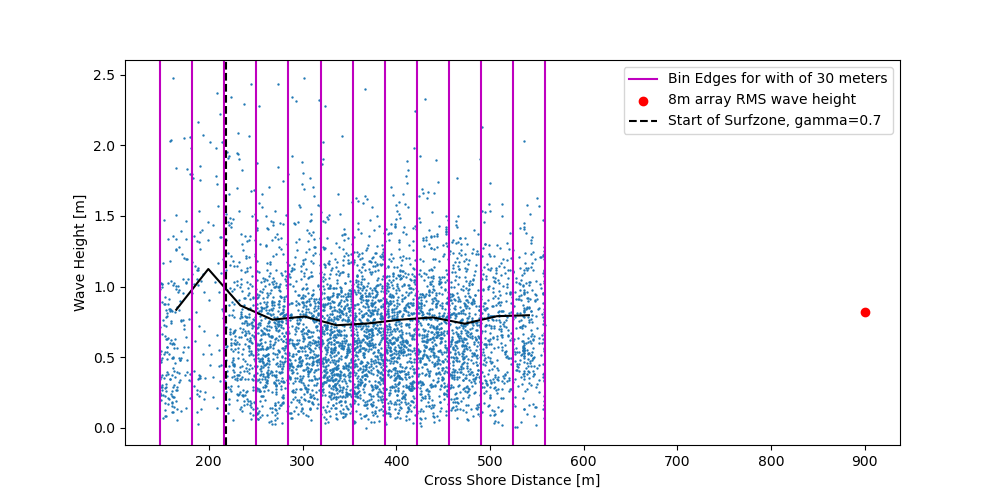

In [13]:
# Plot the cross shore rms wave height profile
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(wave_df['cross shore location [m]'], wave_df['height [m]'], s=0.5)
ax.plot(cross_shore_bin_centers, h_rms_profile, color='k')
for n in range(len(cross_shore_bin_edges)-1):
    ax.axvline(cross_shore_bin_edges[n], color='m')
ax.axvline(cross_shore_bin_edges[-1], color='m', label=f'Bin Edges for with of {cross_shore_bin_size} meters')
ax.scatter(900, Hs_offshore_inmission/1.4, color='r', label='8m array RMS wave height')
ax.axvline(x_surfzone, color='k', linestyle='dashed', label='Start of Surfzone, gamma=0.7')
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Wave Height [m]')
ax.legend()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


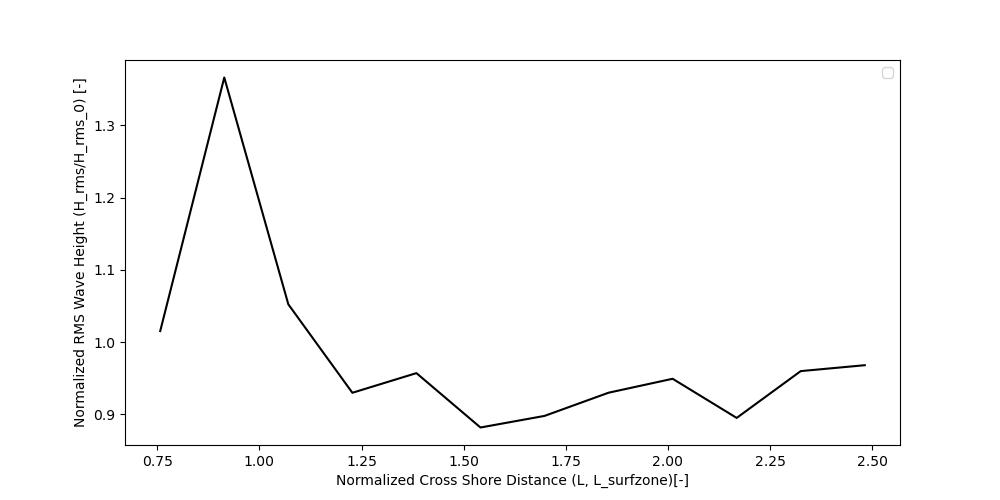

In [14]:
# Normalize the Wave Height by the offshore RMS wave height and normalize 
# distance by surfzone width
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(cross_shore_bin_centers/x_surfzone, h_rms_profile/( Hs_offshore_inmission/1.4), color='k')
ax.set_xlabel('Normalized Cross Shore Distance (L, L_surfzone)[-]')
ax.set_ylabel('Normalized RMS Wave Height (H_rms/H_rms_0) [-]')
ax.legend()

In [15]:
fname = '../data/case_studys/mission19_casestudy_data.csv'
mission_tools.save_case_study_data(fname, h_rms_profile, cross_shore_bin_centers, 
                                   Hs_offshore_inmission, x_surfzone,
                                   Tm_offshore_inmission, mean_dir_offshore_inmission,
                                   wave_frequency, wave_energy_offshore_inmission)